In [2]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [3]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm

In [4]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [5]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [81]:
sample = "er1"
new_sample_name = "MCF7-labo-er1"
quant_params = "trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "old/dsp779"
cell_line="MCF7"
cond = "er1"

### Plotting parameters

In [7]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

### Raw CB frequency

In [10]:
y = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/raw_cb_frequency.txt", header=None)[1]

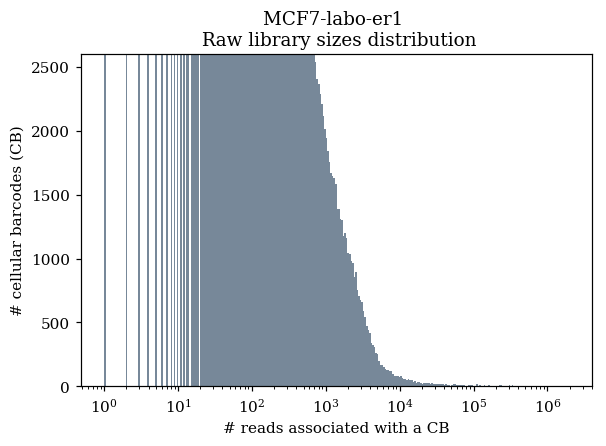

In [14]:
plt.title(f"{new_sample_name} \n Raw library sizes distribution")
plt.ylim(0,2600);
plt.xlabel("# reads associated with a CB")
plt.ylabel("# cellular barcodes (CB)")
rnaseq.plotting.loghist(y, bins=300, color = "lightslategray")

In [16]:
x = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/featureDump.txt")

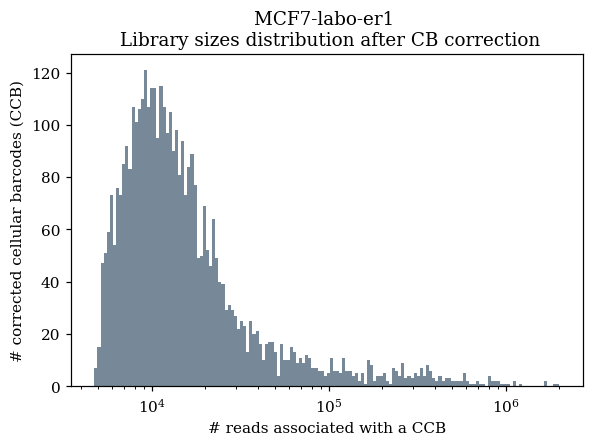

In [17]:
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction")
plt.xlabel("# reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plotting.loghist(x["CorrectedReads"], bins=150, color = "lightslategray")

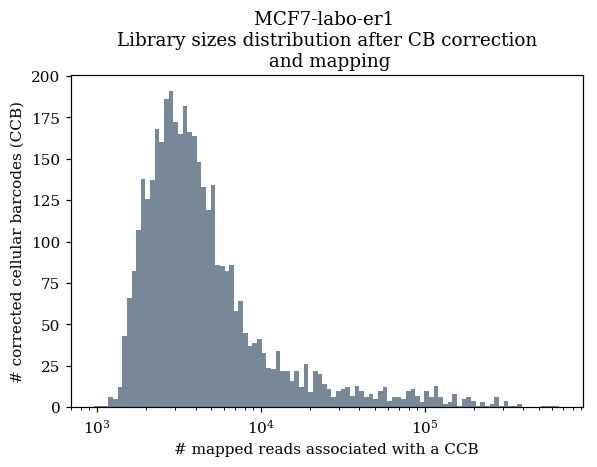

In [18]:
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction \n and mapping")
plt.xlabel("# mapped reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plotting.loghist(x["MappedReads"], bins=100, color = "lightslategray")

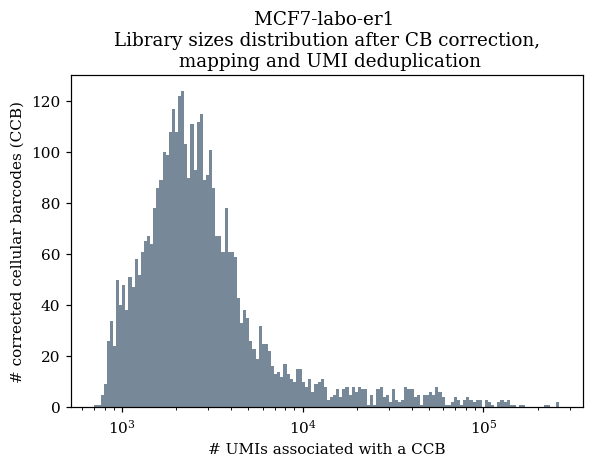

In [22]:
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plotting.loghist(x["DeduplicatedReads"], bins=150, color = "lightslategray")

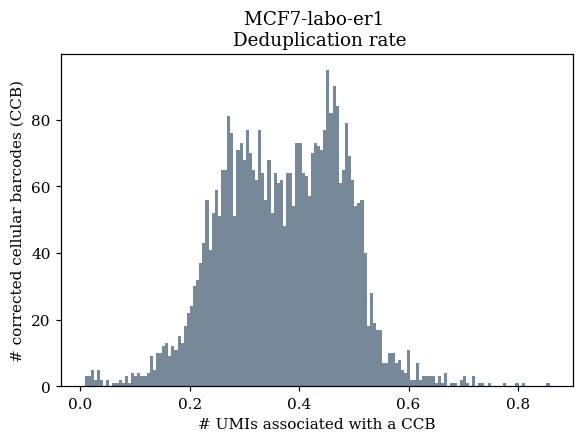

In [21]:
plt.title(f"{new_sample_name} \n Deduplication rate")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
plt.hist(x["DedupRate"], bins=150, color = "lightslategray");

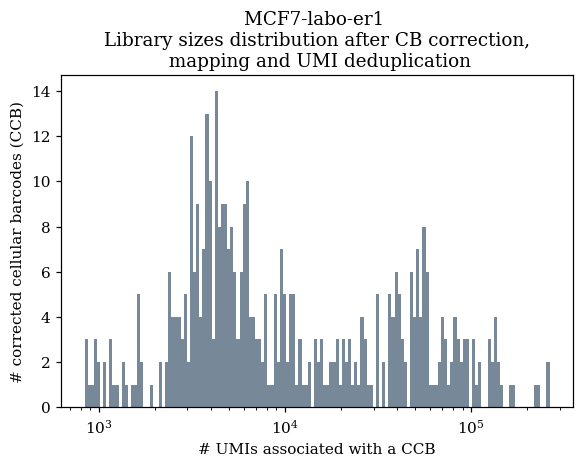

In [20]:
i = x["DedupRate"]<0.5
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plotting.loghist(x["DeduplicatedReads"][~i], bins=150, color = "lightslategray")

### Loading raw count matrix

In [82]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")

rnaseq.setup.annotate_samples(sc, samples_annot_name = "conditions", samples_annot = cond)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "cell_lines", samples_annot = cell_line)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "source", samples_annot = "labo")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "samples", samples_annot = new_sample_name, ow = True)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac")

sc.obs_names = sc.obs["CB"]

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating conditions...
Annotating cell_lines...
Annotating source...
Annotating samples...
Annotating total_UMIs...
Annotating #_genes...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating rp_frac...
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


In [93]:
rb_cbs[:100]

array(['CTGTCTCTTATA', 'GTACTCTGCGTT', 'CCTGTAATCCCA', 'TATCAACGCAGA',
       'CTCTAAATCCCC', 'GTATCAACGCAG', 'ACGCAGAGTGAA', 'AAAAAAAAAAAA',
       'GCATAAGCCTGC', 'ATCTATCACCCT', 'CCCTATAGAAGA', 'TTATTACCCTCA',
       'GGGGGGGGGGGG', 'TCCCAGCACTTT', 'ATATTAATGTAT', 'CTGTAATGCAGT',
       'GTCCAAGATAGA', 'GATTTATAGGTA', 'CCTGTAGTCCCA', 'CTACTAAAAATA',
       'CCATATAATAAA', 'GACAATTAACAG', 'GTCTAGAGCTTG', 'GCCCTGGACCTG',
       'CTATAGAAGAAC', 'GGTGATAGCTGG', 'ATCTACAATCAA', 'GTCCAAAGAGGA',
       'CCCATAGTAGGC', 'GGCCCAAGGTGT', 'CTCCAAGAGTGT', 'AACGCAGAGTGA',
       'GTTTAATCAGAG', 'CTGTAATCCCAG', 'GTGTAACAACCA', 'GCCTTGGACAGC',
       'GGCTGAGGCAGG', 'CCCTGGGAGACA', 'ACTCCAGCCTGG', 'GTCCTGCAGGCT',
       'GTAAAAGACTGG', 'CTAAATCCCCTT', 'GCCCTGGAGGGG', 'GCCTAAAAGCAG',
       'ACTTTAAATTTG', 'GTATAAGTAACA', 'GTCTATAAGAAG', 'GATTAAAACACT',
       'CCTCAGACACGC', 'CCTCTGAGACCC', 'ATATTTGCACCC', 'CTCTTAATCAGT',
       'CCCCTGGACCTG', 'ACATATAACTGA', 'TGTCTCTTATAC', 'GAACTAATGTTA',
      

In [83]:
rb_cbs = np.loadtxt("./rb-cbs.txt", dtype = 'str')
sc.obs["rb-cb"] = [str(cb in rb_cbs) for cb in sc.obs["CB"]]

In [84]:
rb_cbs.shape

(2156,)

In [70]:
sc.obs["total_UMIs"].to_csv("./trimmed_tot_umis.csv")

In [13]:
sc.X.shape

(3994, 60240)

### 1st filtering

#### QC before filtering

##### Umap

Normalization by total UMIs...
Log2 + 1 tranformation...


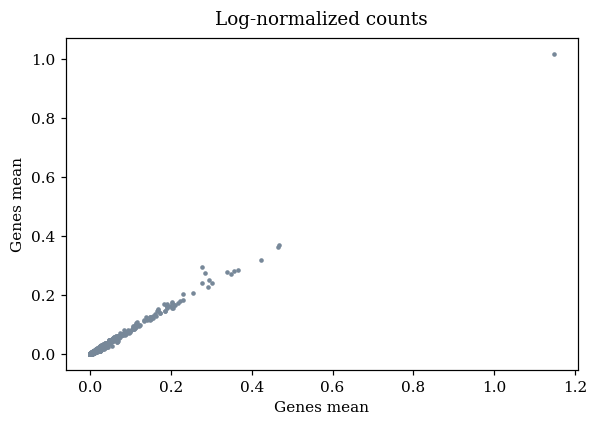

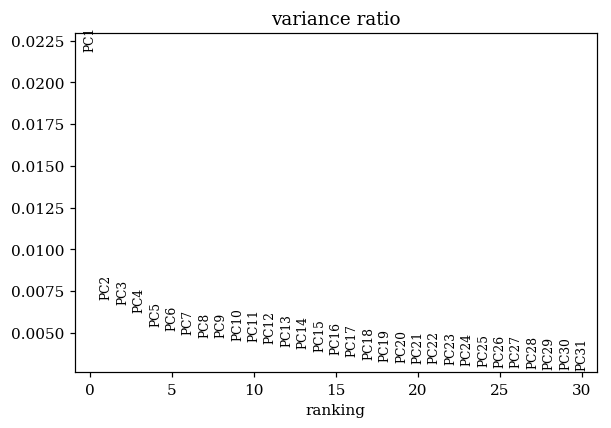

In [85]:
rnaseq.pp.log_norm(sc, plot=True, inplace=True, ow = True)
scanpy.pp.pca(sc)
scanpy.pl.pca_variance_ratio(sc)

In [86]:
scanpy.pp.neighbors(sc, n_pcs = 15, n_neighbors = 15)
scanpy.tl.umap(sc)

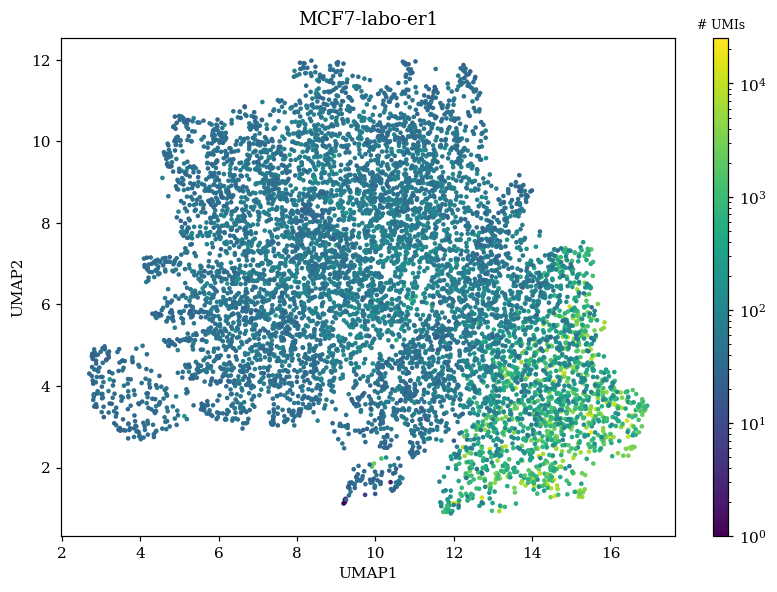

In [88]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["total_UMIs"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "# UMIs", title = new_sample_name)

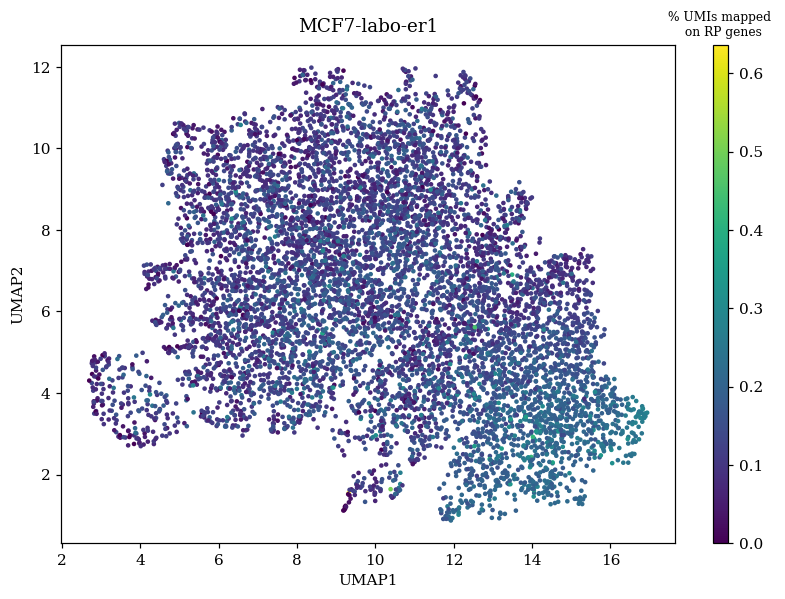

In [87]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["rp_frac"], \
    s = 4, palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on RP genes", title = new_sample_name)

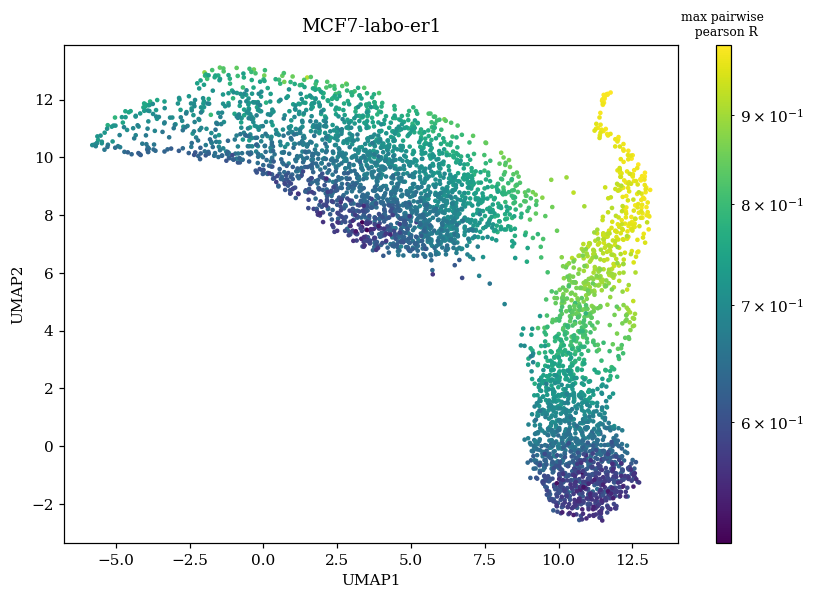

In [607]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

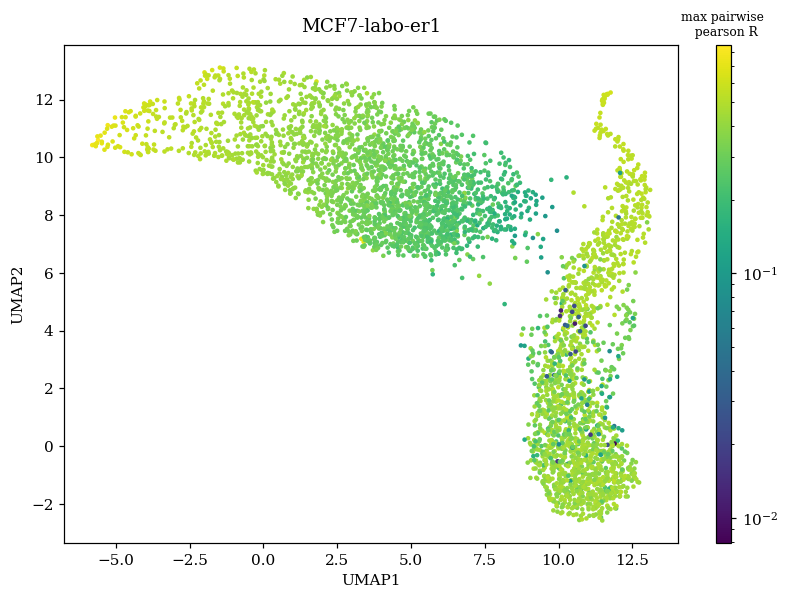

In [608]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["DedupRate"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

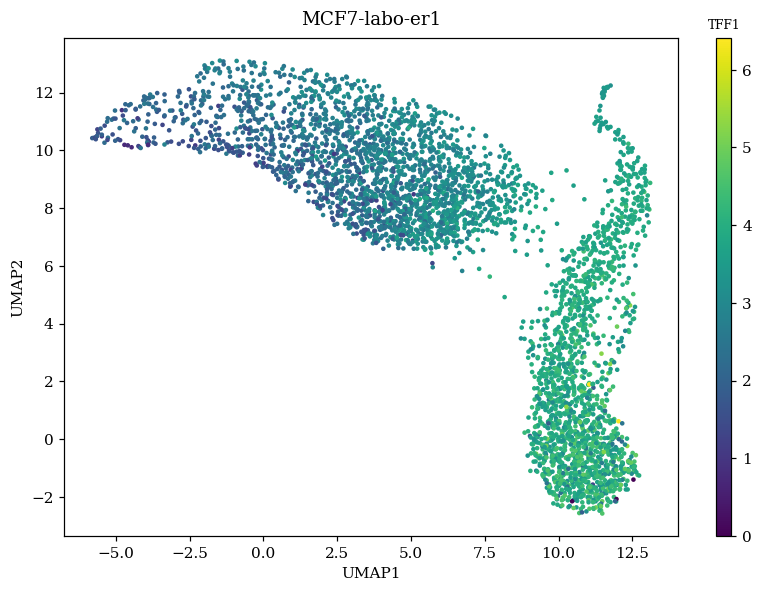

In [629]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.X.toarray()[:, sc.var["external_gene_name"] == "TFF1"].ravel(), \
    s = 4, xlabel="UMAP1", ylabel="UMAP2", color_title = "TFF1", title = new_sample_name)

##### QC metrics distibutions

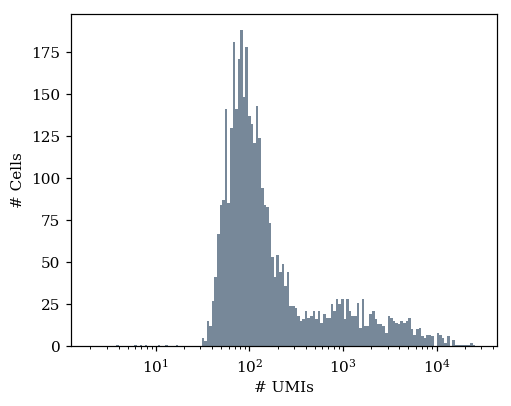

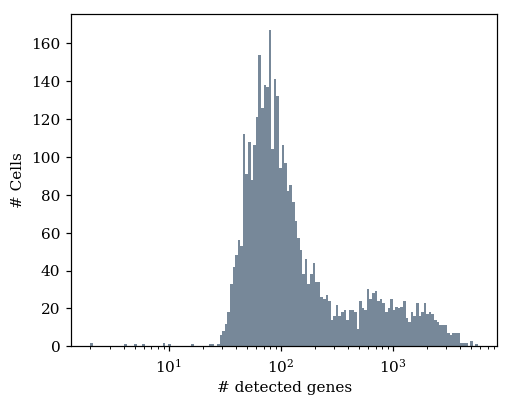

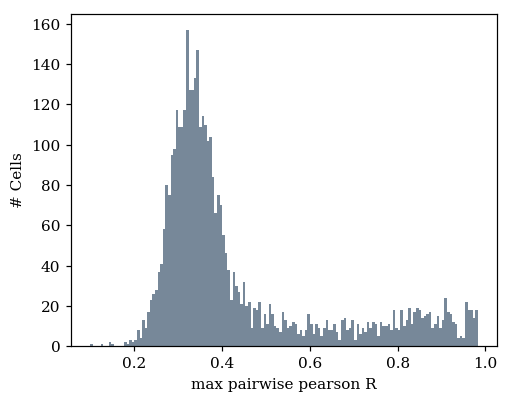

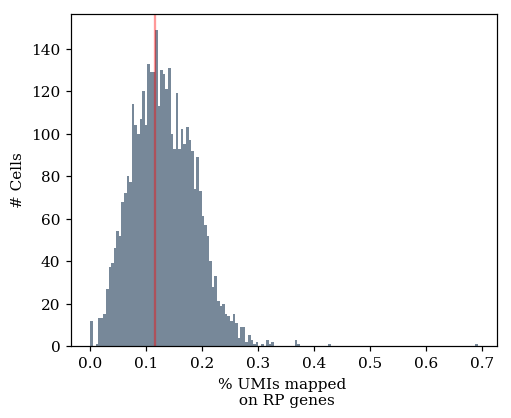

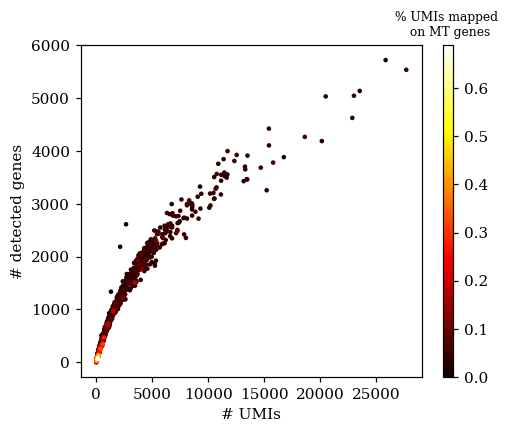

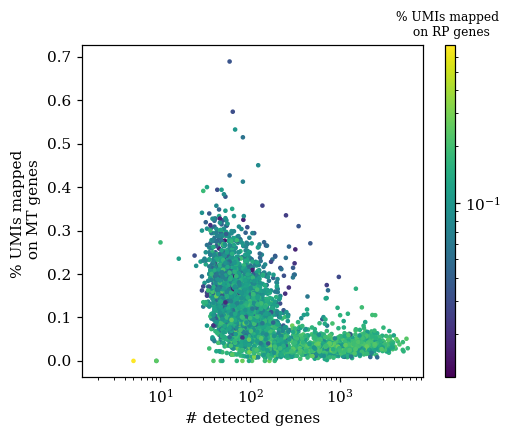

In [29]:
rnaseq.pp.plot_qc(sc,  rp_min = 0.115, n_bins = 150)

#### Test some thresholds

##### Umap

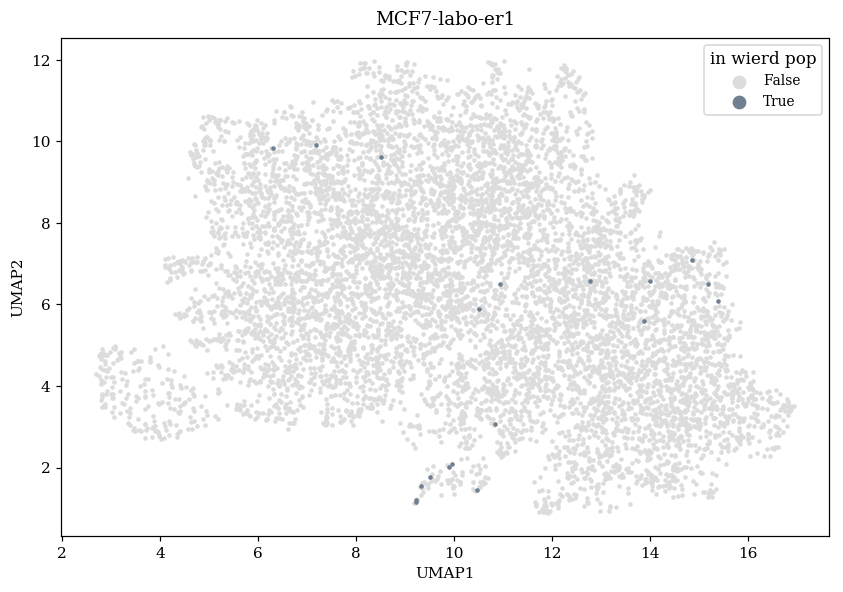

In [89]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["rb-cb"], \
    s = 4, norm = LogNorm(),  palette = {"True" : "slategray", "False" : "gainsboro"}, \
    xlabel="UMAP1", ylabel="UMAP2", color_title = "in wierd pop", title = new_sample_name)

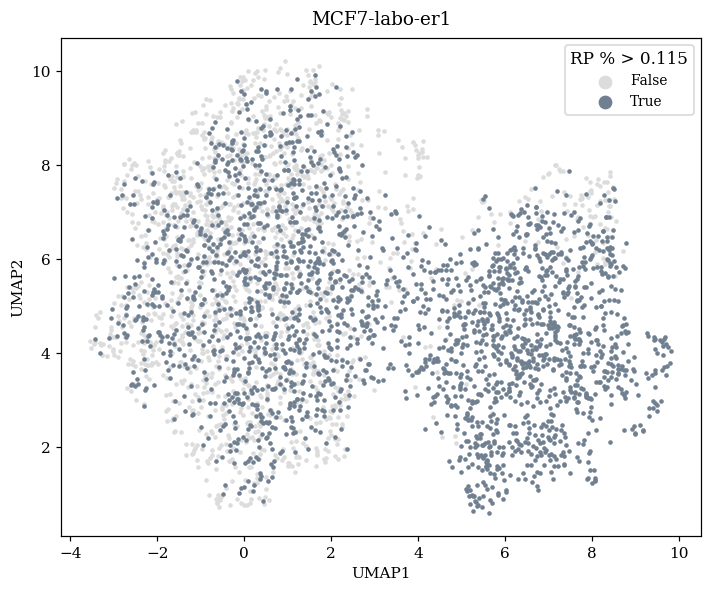

In [65]:
rnaseq.pp.filter_cells(sc, rp_min = 0.115, inplace = False)

plt.subplots(figsize = (7.5,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["keep"], \
    s = 4, norm = LogNorm(), xlabel="UMAP1", ylabel="UMAP2", color_title = "RP % > 0.115", \
    title = new_sample_name, palette = {"True" : "slategray", "False" : "gainsboro"})

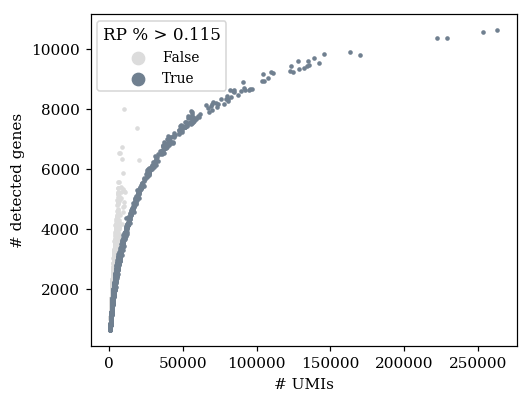

In [627]:
plt.subplots(figsize=(5,4))
rnaseq.plotting.scatter(sc.obs["total_UMIs"], sc.obs["#_genes"], color = sc.obs["keep"], order_color=True, \
s = 4, color_title = "RP % > 0.115", xlabel = "# UMIs", ylabel = "# detected genes", palette = {"True" : "slategray", "False" : "gainsboro"})

Text(0.5, 1.0, 'Log-scale')

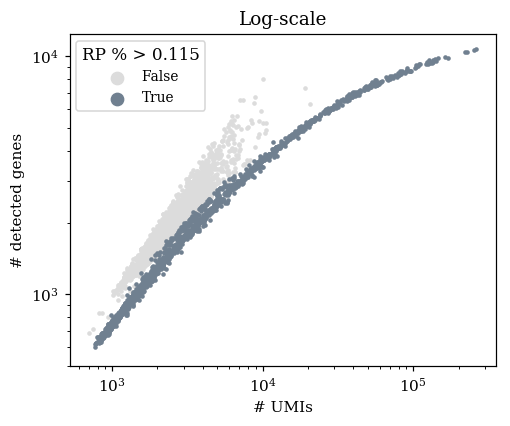

In [628]:
plt.subplots(figsize=(5,4))
rnaseq.plotting.scatter(sc.obs["total_UMIs"], sc.obs["#_genes"], color = sc.obs["keep"], order_color=True, \
s = 4, color_title = "RP % > 0.115", xlabel = "# UMIs", ylabel = "# detected genes", palette = {"True" : "slategray", "False" : "gainsboro"})
plt.xscale("log")
plt.yscale("log")
plt.title("Log-scale")

##### DEA

In [366]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="keep", method = "wilcoxon", groups=["False"], reference="True", n_genes=2000, rankby_abs=True)

/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = pd.DataFrame(np.array(data[gene_set_library])[:,1:], columns=["Term", "P-value", "Z-score", "Combined Score", "Genes", "Adjusted P-value", "Old P-value", "Old adjusted P-value"])
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous 

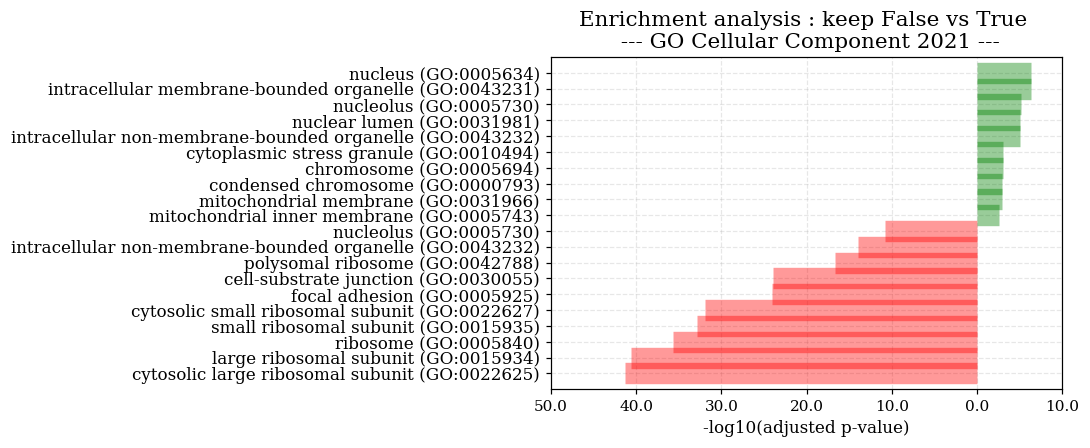

In [367]:
rnaseq.dea.enrichr(sc, group = "False", libraries="GO_Cellular_Component_2021", lfc_cutoff=0.5);

#### Filtering cells

In [591]:
rnaseq.pp.filter_cells(sc, rp_min = 0.115, inplace = True)

#### Number of cells after filtering

In [369]:
sc.X.shape

(1843, 20305)

### 2nd filtering

In [ ]:
import doubletdetection

clf = doubletdetection.BoostClassifier()
# raw_counts is a cells by genes count matrix
labels = clf.fit(sc.layers["raw"].toarray()).predict()
# higher means more likely to be doublet
scores = clf.doublet_score()

#### QC before filtering

##### Umap

Normalization by total UMIs...
Log2 + 1 tranformation...


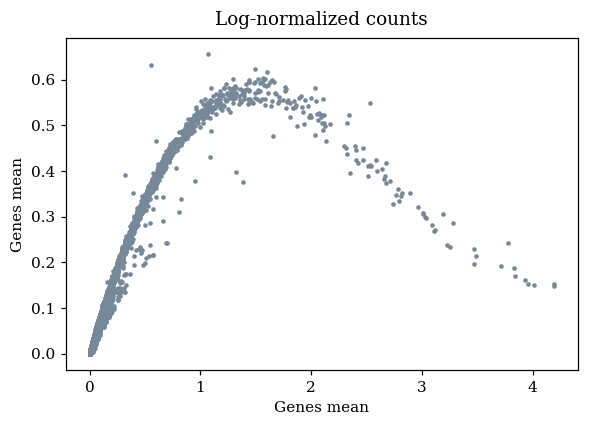

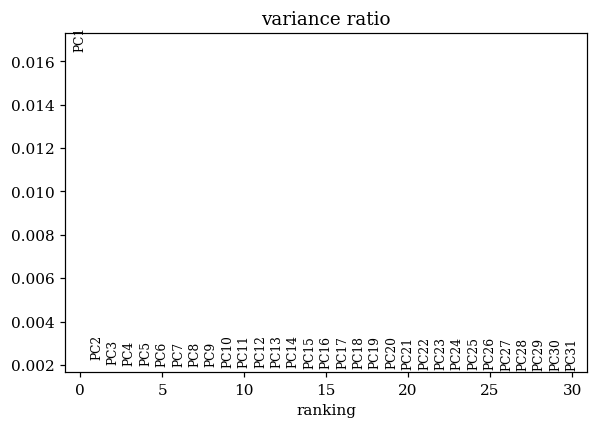

In [592]:
rnaseq.pp.log_norm(sc, plot=True, inplace=True, ow = True)
scanpy.pp.pca(sc)
scanpy.pl.pca_variance_ratio(sc)

In [593]:
scanpy.pp.neighbors(sc, n_pcs = 30, n_neighbors = 30)
scanpy.tl.umap(sc, spread = 2)

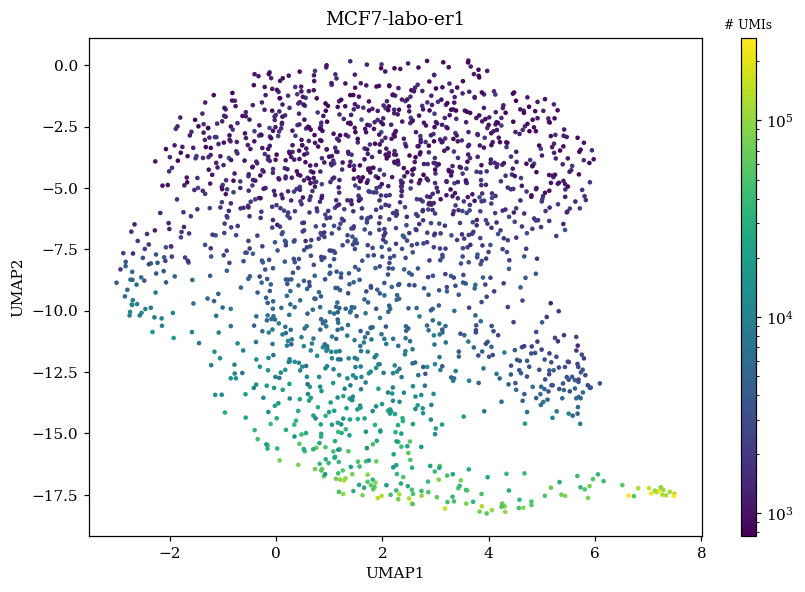

In [594]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["total_UMIs"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "# UMIs", title = new_sample_name)

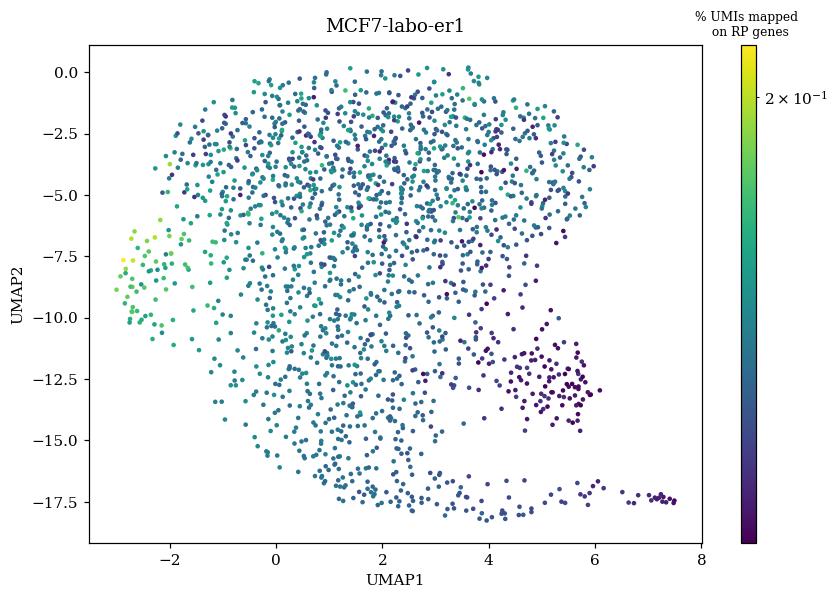

In [484]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["rp_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on RP genes", title = new_sample_name)

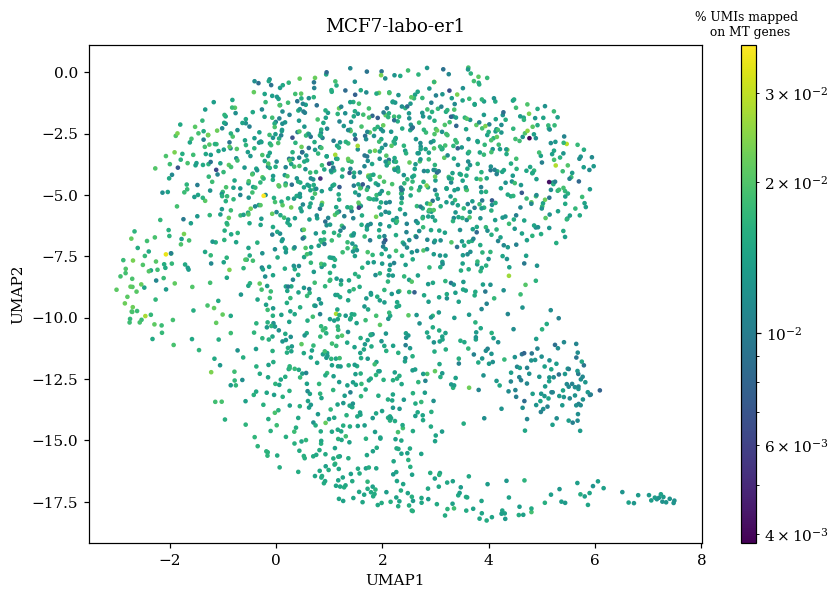

In [485]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["mt_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on MT genes", title = new_sample_name)

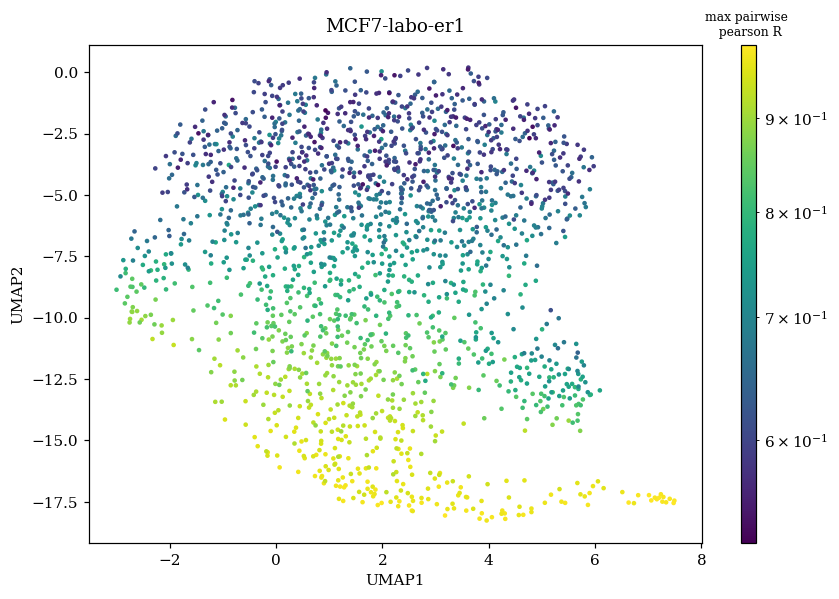

In [486]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

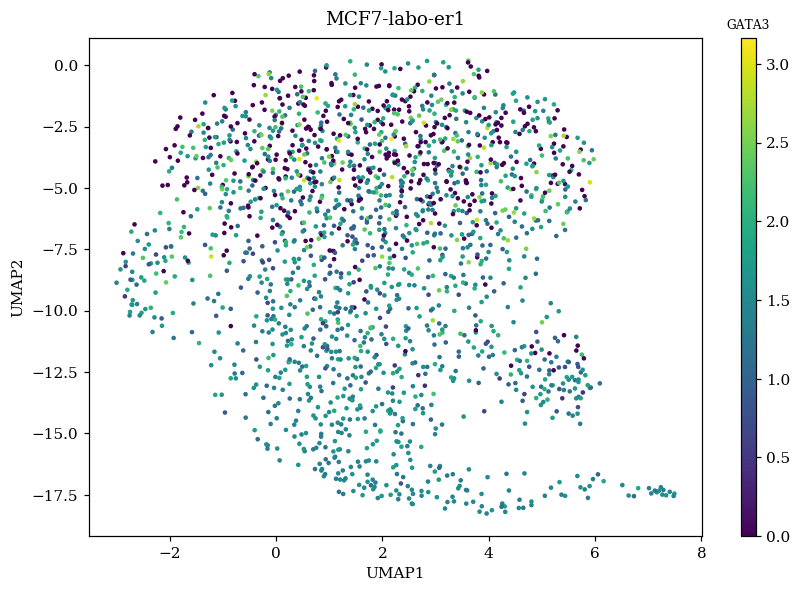

In [597]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.X.toarray()[:, sc.var["external_gene_name"] == "GAPDH"].ravel(), \
    s = 4, xlabel="UMAP1", ylabel="UMAP2", color_title = "GATA3", title = new_sample_name)

##### QC metrics distibutions

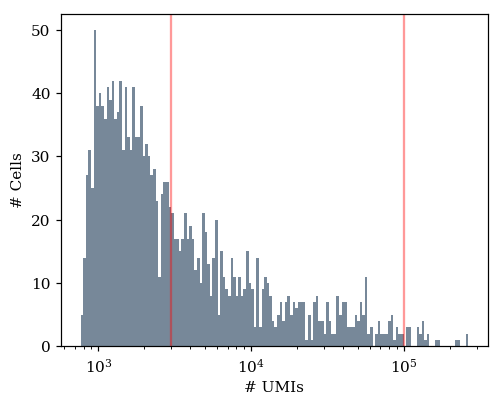

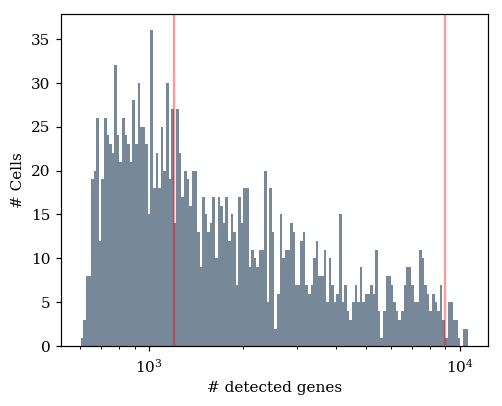

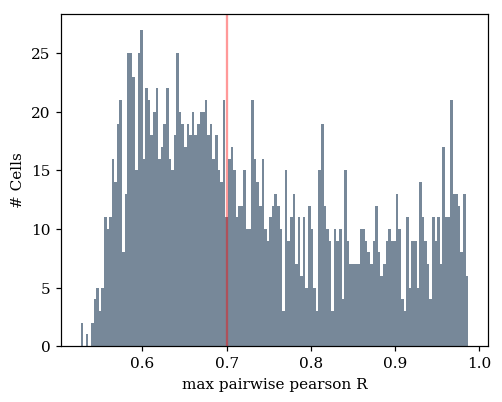

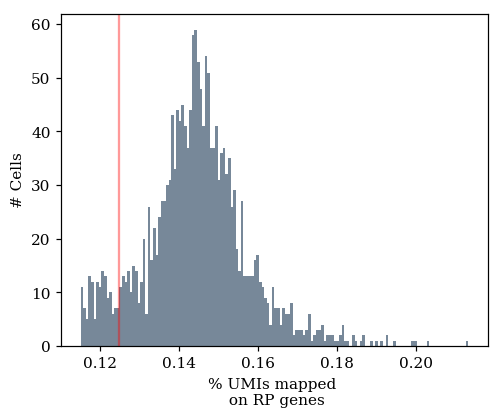

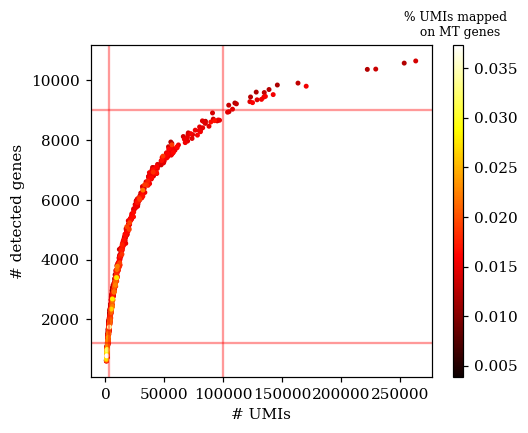

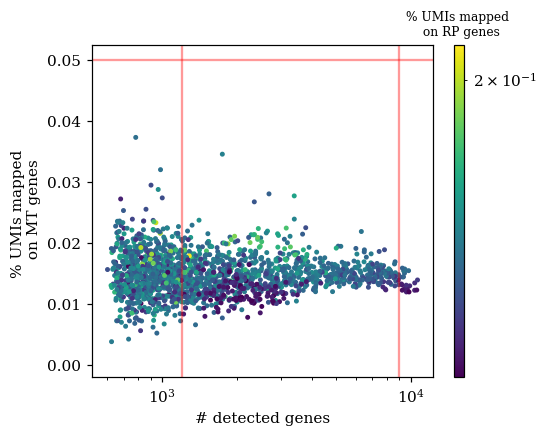

In [487]:
rnaseq.pp.plot_qc(sc, n_counts_max=100000, n_counts_min = 2000, n_genes_max=9000, n_genes_min = 1000, mt_max = 0.05, max_corr_thr = 0.72, rp_min = 0.13, n_bins = 150)

#### Test some thresholds

##### Umap

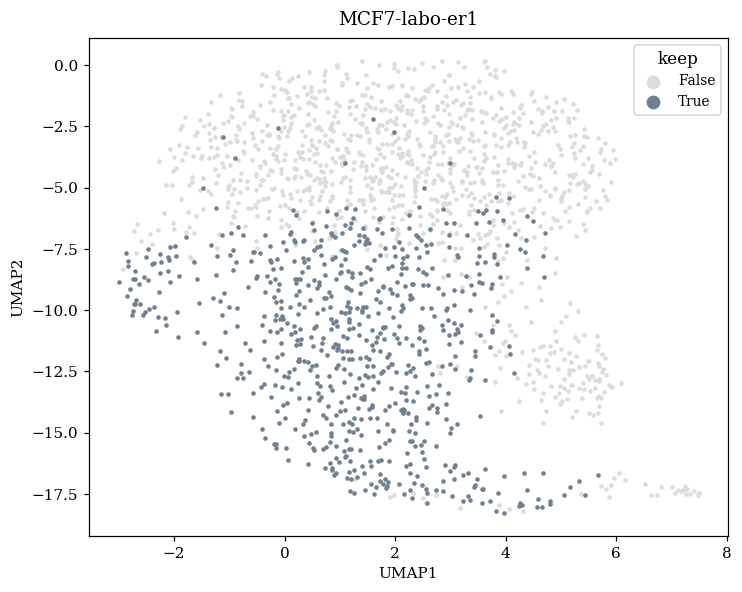

In [506]:
rnaseq.pp.filter_cells(sc, n_counts_max=100000, n_counts_min = 2000, n_genes_max=9000, n_genes_min = 1000, mt_max = 0.05, max_corr_thr = 0.72, rp_min = 0.13, inplace = False)

plt.subplots(figsize = (7.5,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["keep"], \
    s = 4, norm = LogNorm(), xlabel="UMAP1", ylabel="UMAP2", color_title = "keep", \
    title = new_sample_name, palette = {"True" : "slategray", "False" : "gainsboro"})

##### DEA

In [462]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="keep", method = "wilcoxon", groups=["True"], reference="False", n_genes=2000, rankby_abs=True)

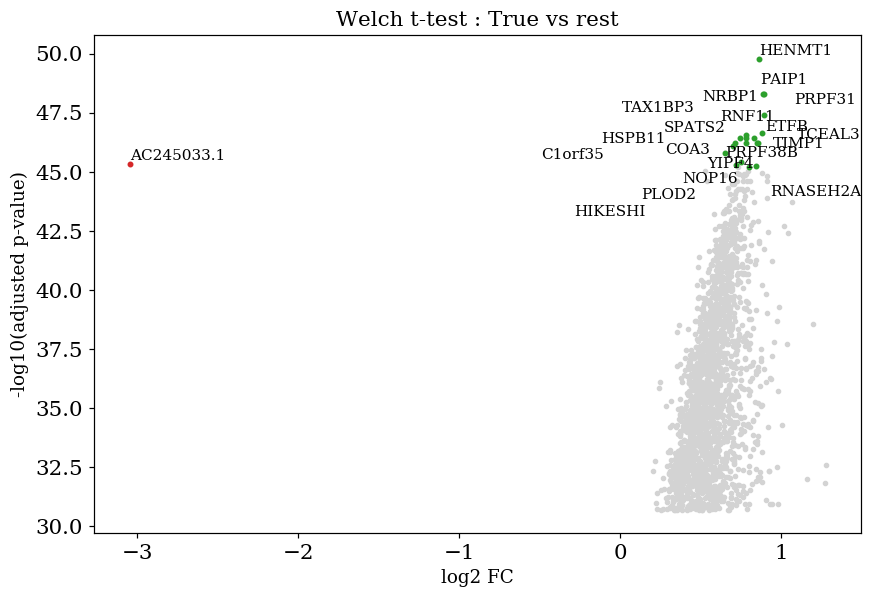

In [463]:
rnaseq.dea.volcano_plot(sc, group = "True")

#### Filtering cells

In [559]:
rnaseq.pp.filter_cells(sc, n_counts_max=100000, n_counts_min = 2000, n_genes_max=9000, n_genes_min = 1000, mt_max = 0.05, max_corr_thr = 0.72, rp_min = 0.13, inplace = True)

#### Number of cells after filtering

In [508]:
sc.X.shape

(723, 20305)

### 3rd filtering

#### QC before filtering

##### Umap

Normalization by total UMIs...
Log2 + 1 tranformation...


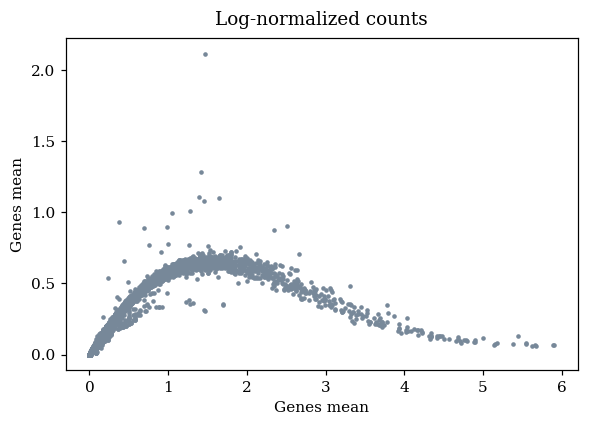

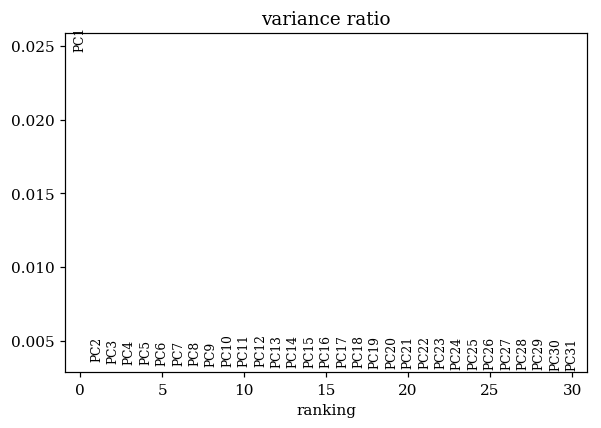

In [560]:
rnaseq.pp.log_norm(sc, plot=True, inplace=True, ow = True)
scanpy.pp.pca(sc, use_highly_variable=False)
scanpy.pl.pca_variance_ratio(sc)

In [561]:
scanpy.pp.neighbors(sc, n_pcs = 30, n_neighbors = 30)
scanpy.tl.umap(sc, spread = 2)

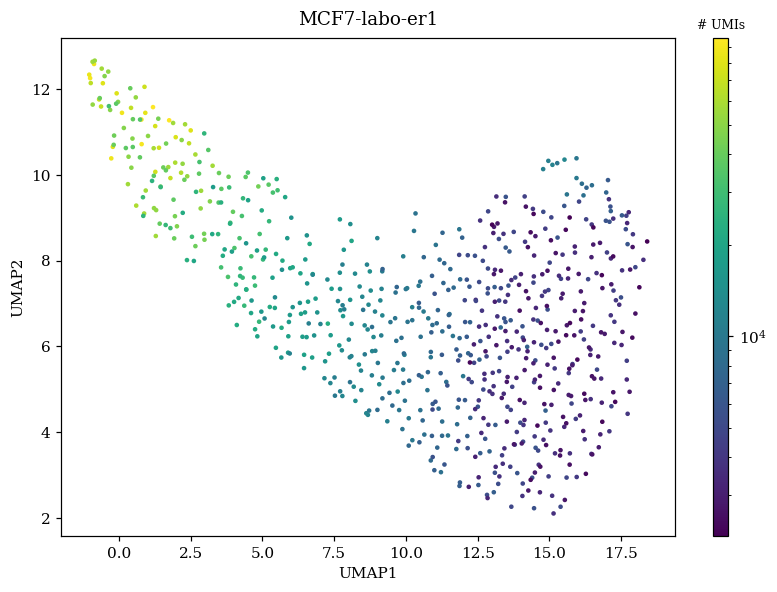

In [562]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["total_UMIs"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "# UMIs", title = new_sample_name)

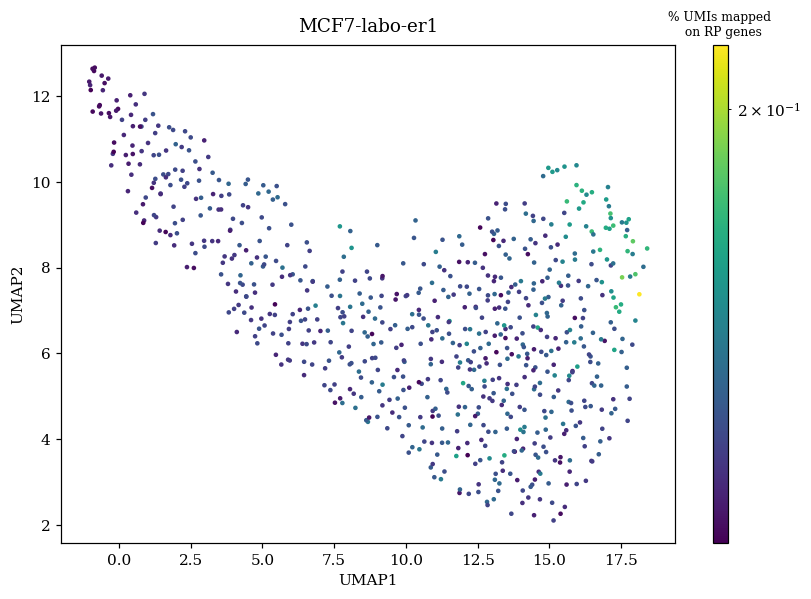

In [533]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["rp_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on RP genes", title = new_sample_name)

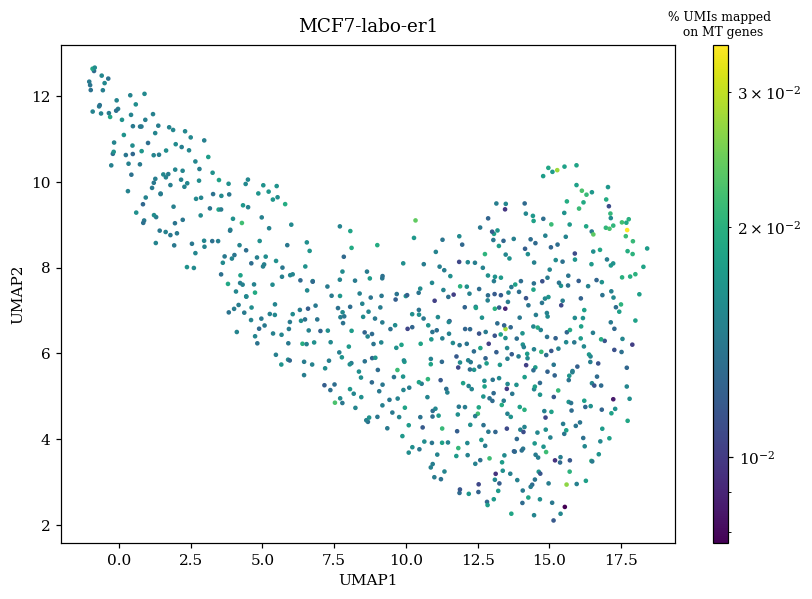

In [534]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["mt_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on MT genes", title = new_sample_name)

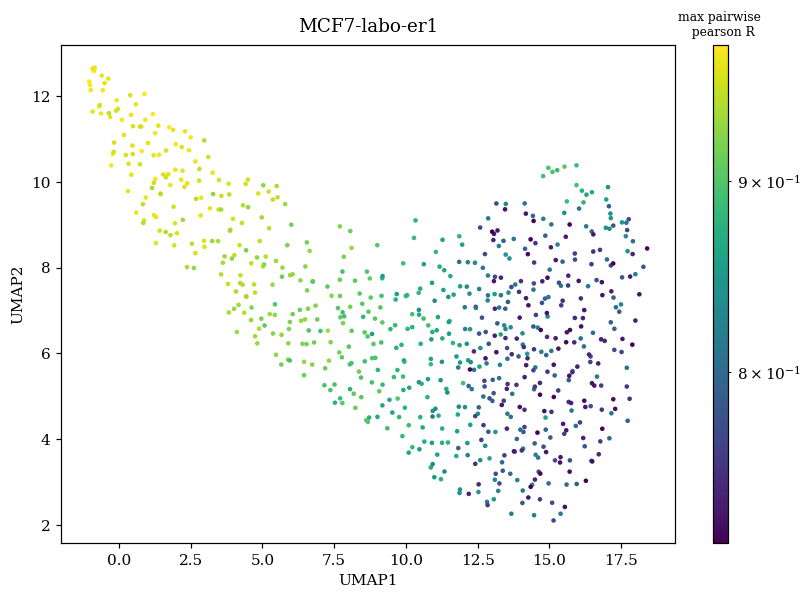

In [535]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

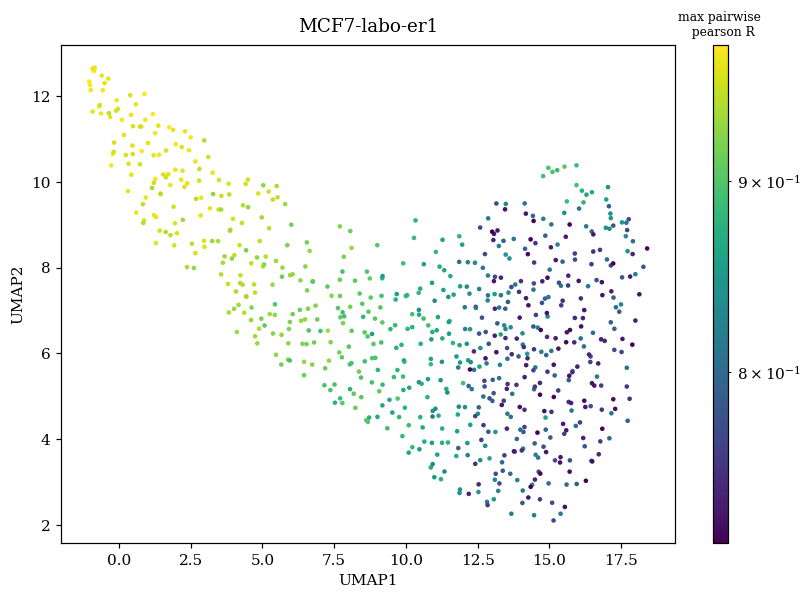

In [535]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

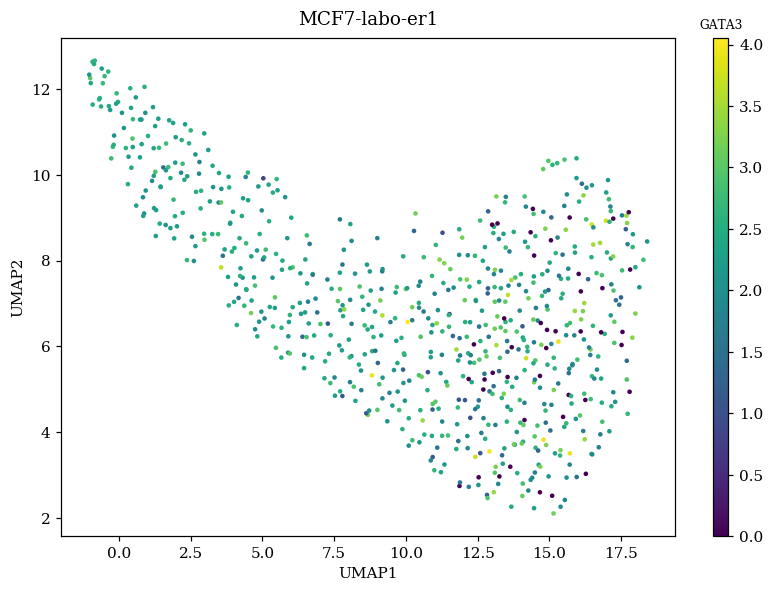

In [589]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.X.toarray()[:, sc.var["external_gene_name"] == "GATA3"].ravel(), \
    s = 4, xlabel="UMAP1", ylabel="UMAP2", color_title = "GATA3", title = new_sample_name)

##### QC metrics distibutions

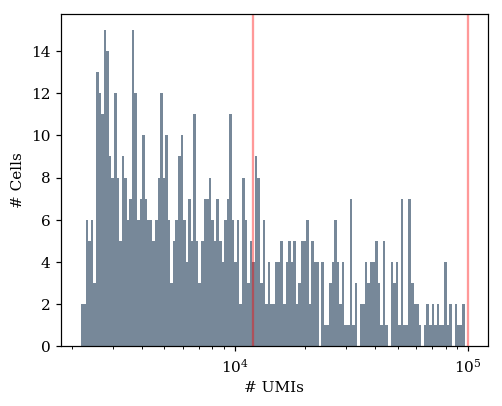

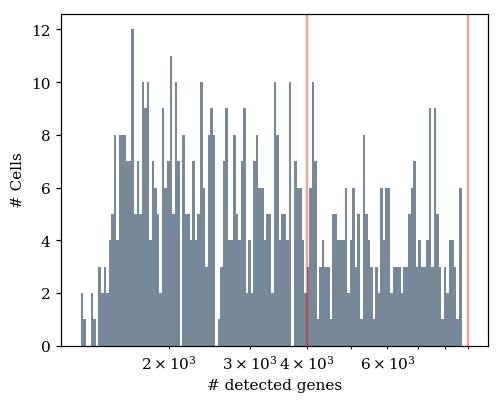

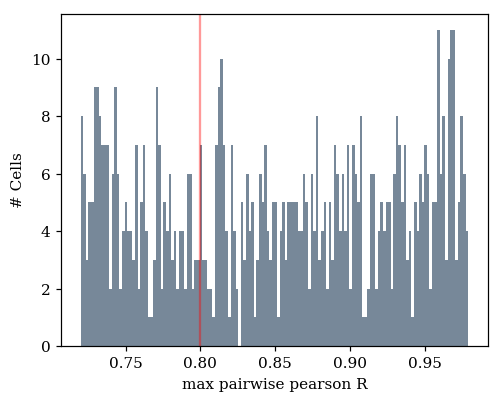

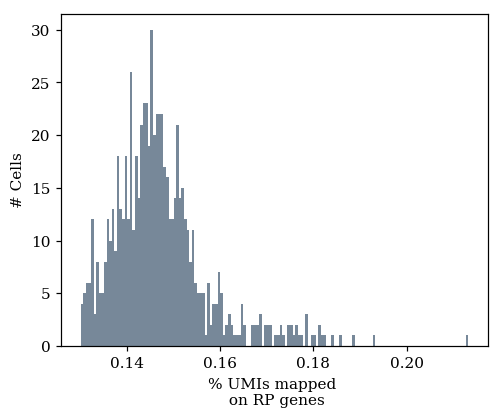

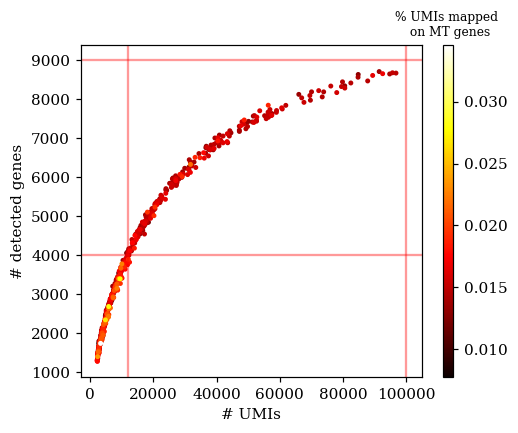

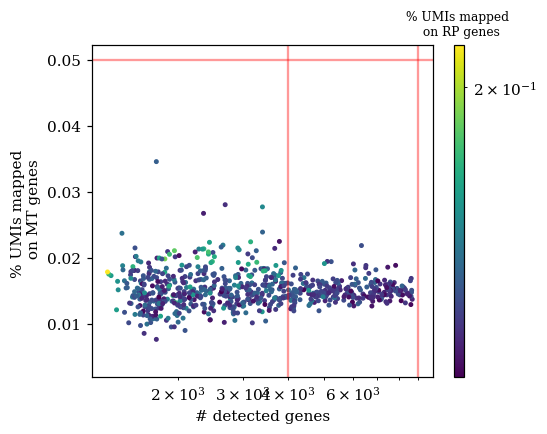

In [582]:
rnaseq.pp.plot_qc(sc, n_counts_max=100000, n_counts_min = 12000, n_genes_max=9000, n_genes_min = 4000, mt_max = 0.05, max_corr_thr = 0.8, n_bins = 150)

#### Test some thresholds

##### Umap

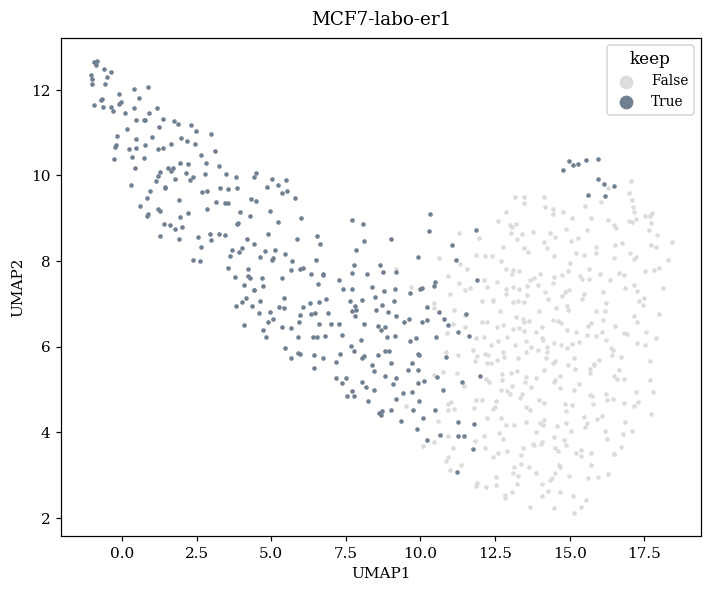

In [580]:
rnaseq.pp.filter_cells(sc, n_counts_max=100000, n_counts_min = 8000, n_genes_max=9000, n_genes_min = 3000, mt_max = 0.05, max_corr_thr = 0.8, inplace = False)

plt.subplots(figsize = (7.5,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["keep"], \
    s = 4, norm = LogNorm(), xlabel="UMAP1", ylabel="UMAP2", color_title = "keep", \
    title = new_sample_name, palette = {"True" : "slategray", "False" : "gainsboro"})

##### DEA

In [577]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="keep", method = "wilcoxon", groups=["True"], reference="False", n_genes=2000, rankby_abs=True)

... storing 'samples' as categorical
... storing 'project_id' as categorical
... storing 'conditions' as categorical
... storing 'cell_lines' as categorical
... storing 'source' as categorical
... storing 'keep' as categorical
... storing 'chromosome_name' as categorical
... storing 'external_gene_name' as categorical


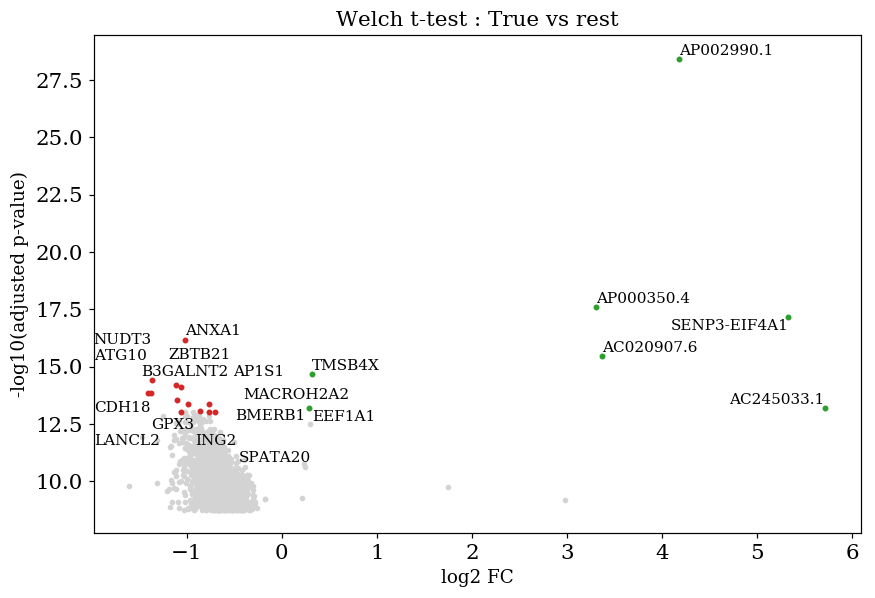

In [578]:
rnaseq.dea.volcano_plot(sc, group = "True")

#### Filtering cells

In [550]:
rnaseq.pp.filter_cells(sc, n_counts_max=100000, n_counts_min = 5000, n_genes_max=9000, n_genes_min = 2500, mt_max = 0.05, max_corr_thr = 0.77, inplace = True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


#### Number of cells after filtering

In [551]:
sc.X.shape

(434, 20305)

### Final dataset

##### Umap

Normalization by total UMIs...
Log2 + 1 tranformation...


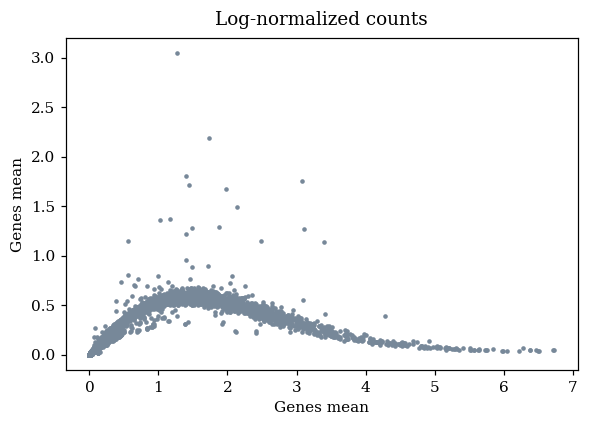

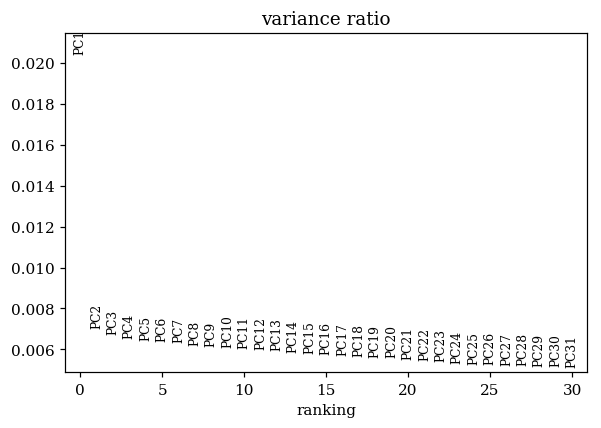

In [552]:
rnaseq.pp.log_norm(sc, plot=True, inplace=True, ow = True)
scanpy.pp.highly_variable_genes(sc)
scanpy.pp.pca(sc, use_highly_variable=True)
scanpy.pl.pca_variance_ratio(sc)

In [553]:
scanpy.pp.neighbors(sc, n_pcs = 15, n_neighbors = 30)
scanpy.tl.umap(sc, spread = 2)

In [462]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="keep", method = "wilcoxon", groups=["True"], reference="False", n_genes=2000, rankby_abs=True)

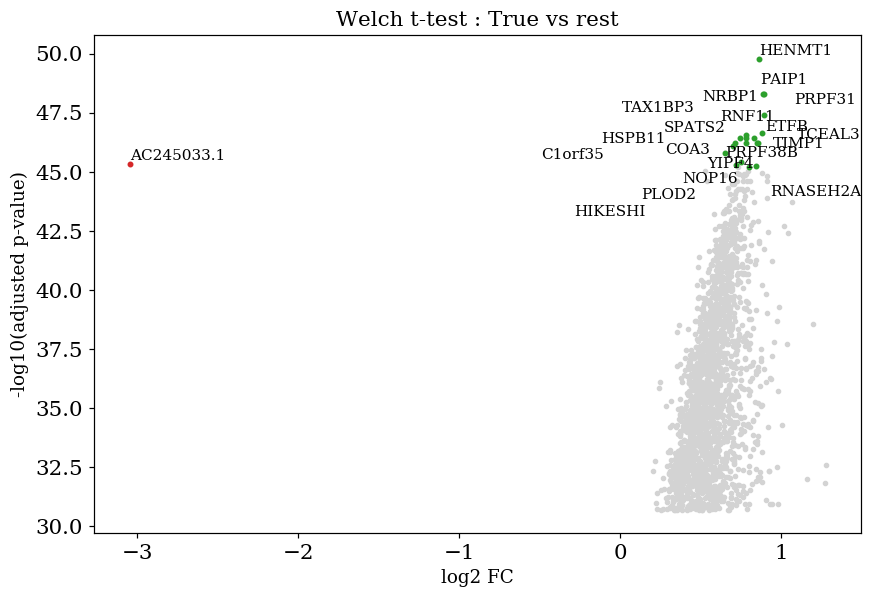

In [463]:
rnaseq.dea.volcano_plot(sc, group = "True")

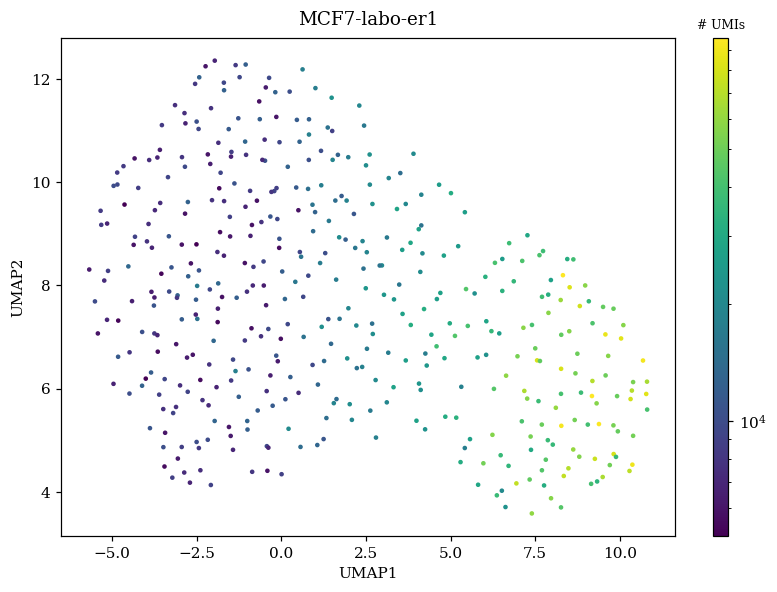

In [555]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["total_UMIs"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "# UMIs", title = new_sample_name)

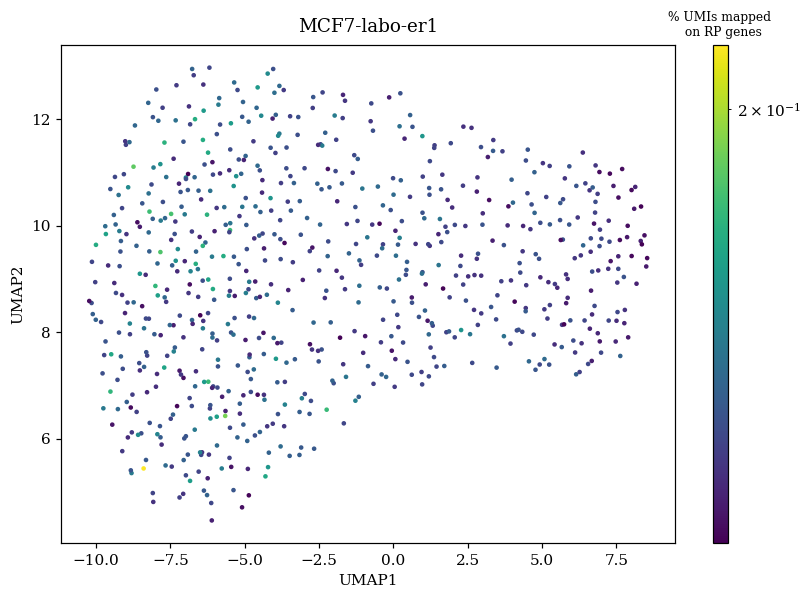

In [524]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["rp_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on RP genes", title = new_sample_name)

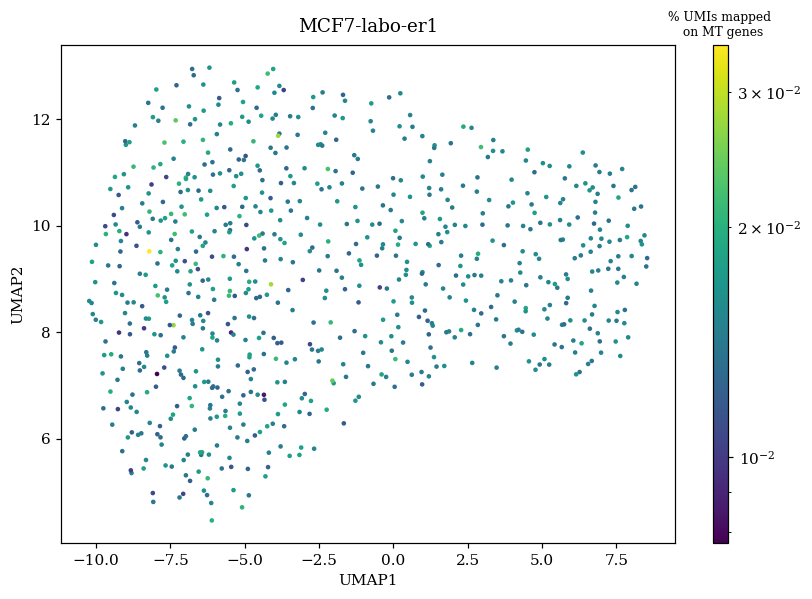

In [525]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["mt_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on MT genes", title = new_sample_name)

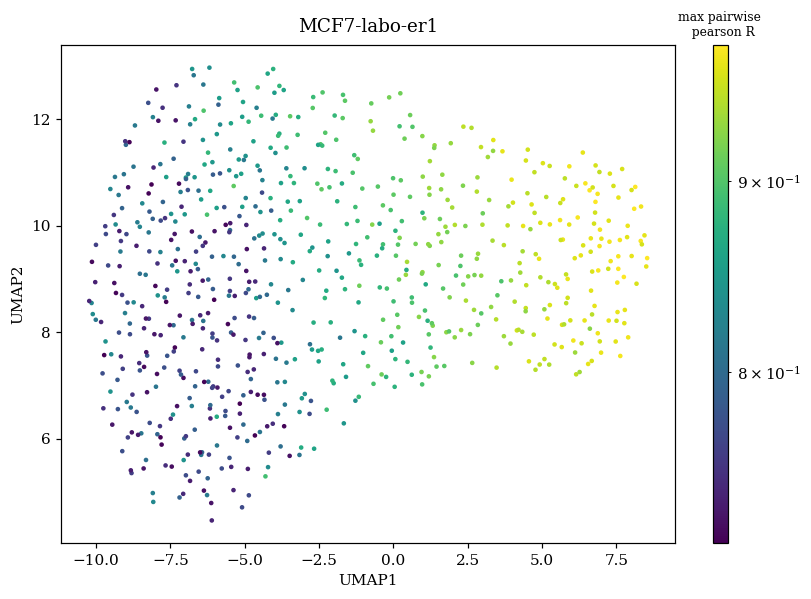

In [526]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

##### QC metrics distibutions

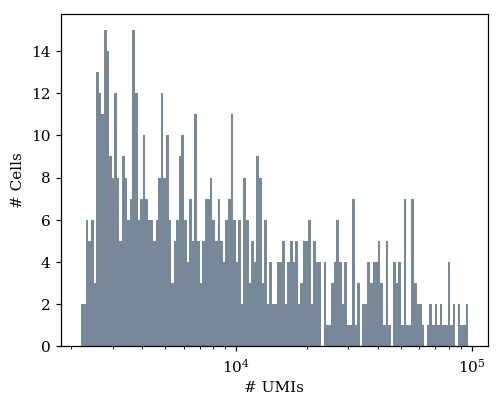

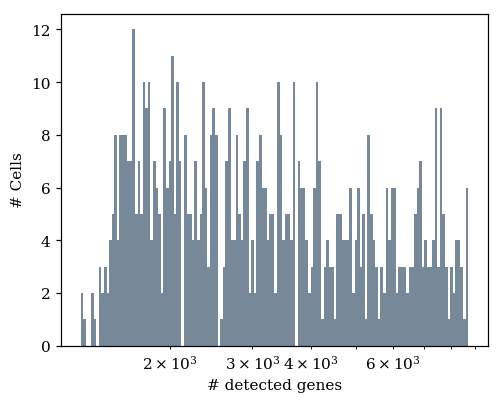

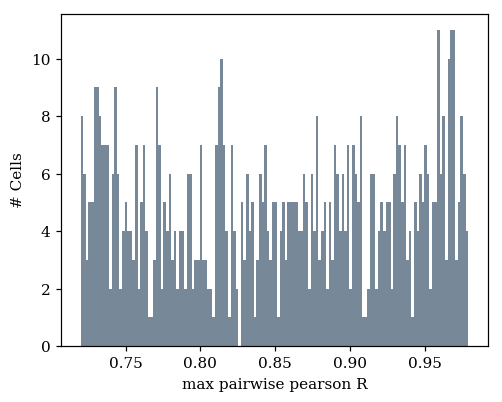

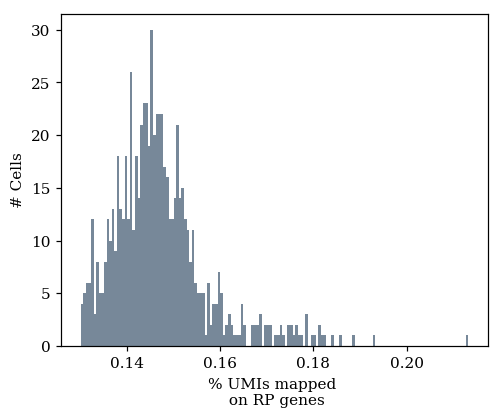

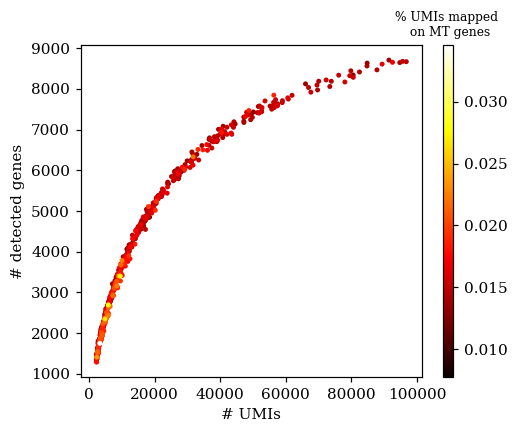

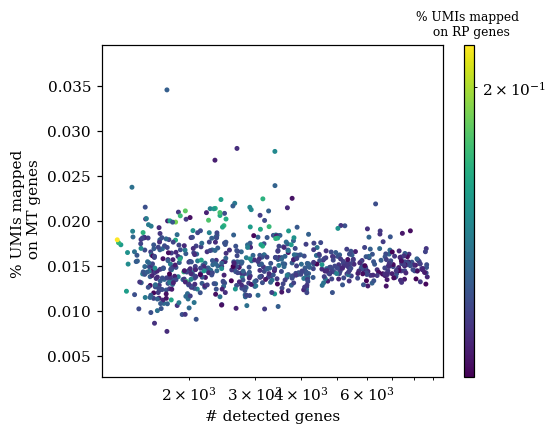

In [511]:
rnaseq.pp.plot_qc(sc)

### Write filtered anndata

In [576]:
del sc.layers["log_norm"]
rnaseq.setup.load_layer(sc, "raw")
sc._inplace_subset_obs(sc.obs["keep"])
rnaseq.readwrite.write_filtered(sc, "/home/arion/davidm/Data/datasets/processed/Projects/scBC-Analysis/filtered_data")

... storing 'samples' as categorical
... storing 'project_id' as categorical
... storing 'conditions' as categorical
... storing 'cell_lines' as categorical
... storing 'source' as categorical
... storing 'chromosome_name' as categorical
... storing 'external_gene_name' as categorical
